<a href="https://colab.research.google.com/github/ekaterinatao/house_md_tg_bot/blob/main/notebooks/NLP_2_HW1_house_md_bot_bi_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi-Encoder BERT
Предобработанный [датасет](https://huggingface.co/datasets/ekaterinatao/house_md_context3), используемый для дообучения модели.  
Отчет обучения на [wandb](https://api.wandb.ai/links/taoea/ja6ugb2u).  
Сохраненный чекпойнт дообученной модели на [huggingface](https://huggingface.co/ekaterinatao/house-md-bot-bert-bi-encoder/tree/main).

In [ ]:
!pip install transformers accelerate>=0.21.0 datasets evaluate wandb faiss-cpu -q -U

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
import random
from tqdm import tqdm
import faiss
from typing import Callable, Iterable
from dataclasses import dataclass

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
import wandb

Код основан на ноутбуке с семинара.  
Параметры обучения:  
* 1 эпоха, т.к. далее модель на валидации выходит на плато  
* 2 класса: положительные и негативные примеры  
* размер батча и learning rate взяты как в примере ноутбука из семинара  

In [ ]:
@dataclass
class TrainingConfig:
    seed = 64
    dataset = 'ekaterinatao/house_md_context3'
    checkpoint = 'distilbert-base-uncased'
    token_length = 128
    n_classes = 2
    batch_size = 16
    train_ratio = 0.8
    device = "cuda" if torch.cuda.is_available() else "cpu"
    learning_rate = 2e-6
    num_epochs = 1

config = TrainingConfig()
print(f'device is {config.device}')

device is cuda


In [ ]:
seed = config.seed

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Датасет

In [ ]:
dataset = datasets.load_dataset(config.dataset, split='train')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/77505 [00:00<?, ? examples/s]

Dataset({
    features: ['answer', 'question', 'context', 'labels', 'joined'],
    num_rows: 77505
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenized_answer = tokenizer([
    data["answer"] for data in dataset],
    max_length=config.token_length, padding="max_length",
    truncation=True, verbose=True
)

tokenized_context = tokenizer(
    ['[SEP]'.join(data["context"]+data['question']) for data in dataset],
    max_length=config.token_length, padding="max_length",
    truncation=True, verbose=True
)

In [ ]:
class BiEncDataset(Dataset):
    def __init__(self, answer_tokens: dict, context_tokens: dict, labels: Iterable[str]):
        self.answer_tokens = answer_tokens
        self.context_tokens = context_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.answer_tokens["input_ids"], self.answer_tokens["attention_mask"],
            self.context_tokens["input_ids"], self.context_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["answer_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["answer_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["context_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["context_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
house_dataset = BiEncDataset(
    tokenized_answer, tokenized_context, (data["labels"] for data in dataset)
)

In [ ]:
config.n_total = len(house_dataset)
config.n_train = int(config.n_total * config.train_ratio)
config.n_val = config.n_total - config.n_train

train_dataset, val_dataset = random_split(
    house_dataset, [config.n_train, config.n_val]
)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

### Bi-Encoder модель

In [ ]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel,
           device: str = "cpu") -> torch.tensor:
    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=config.token_length,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(config.device),
                         tokenized_texts["attention_mask"].to(config.device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(config.device))
    return pooled_embeds

In [ ]:
class BiEncBert(torch.nn.Module):
    def __init__(self, max_length: int = config.token_length):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(config.checkpoint)
        self.bert_tokenizer = AutoTokenizer.from_pretrained(config.checkpoint)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, config.n_classes)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        answer_input_ids = data["answer_input_ids"].to(config.device)
        answer_attention_mask = data["answer_attention_mask"].to(config.device)
        context_input_ids = data["context_input_ids"].to(config.device)
        context_attention_mask = data["context_attention_mask"].to(config.device)

        out_answer = self.bert_model(answer_input_ids, answer_attention_mask)
        out_context = self.bert_model(context_input_ids, context_attention_mask)
        answer_embeds = out_answer.last_hidden_state
        context_embeds = out_context.last_hidden_state

        pooled_answer_embeds = mean_pool(answer_embeds, answer_attention_mask)
        pooled_context_embeds = mean_pool(context_embeds, context_attention_mask)

        embeds =  torch.cat([pooled_answer_embeds, pooled_context_embeds,
                             torch.abs(pooled_answer_embeds - pooled_context_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [ ]:
model = BiEncBert().to(config.device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
config.total_steps = config.n_train // config.batch_size
config.warmup_steps = int(0.1 * config.total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=config.warmup_steps,
    num_training_steps=config.total_steps - config.warmup_steps
)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(config.device))
        mini_batch_losses.append(loss)
        if i % (config.batch_size * 15) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")
            if is_training:
                wandb.log({"step": i, "train_loss":loss})
            else:
                wandb.log({"step": i, "val_loss":loss})

    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
wandb_config = {
    "model": config.checkpoint,
    "dataset": config.dataset,
    "num_classes": config.n_classes,
    "token_length": config.token_length,
    "batch_size": config.batch_size,
    "learning_rate": config.learning_rate,
    "num_epochs": config.num_epochs,
    "optimizer": optimizer,
    "loss_fn": loss_fn
}
wandb.init(
    project='house-md-bot-bi-encoder',
    notes='1 epoch',
    config=wandb_config
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, config.num_epochs + 1):
    print(f'Epoch: {epoch}')
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)

Epoch: 1

Training ...
step     0/3876, loss =  0.701
step   240/3876, loss =  0.329
step   480/3876, loss =  0.305
step   720/3876, loss =  0.166
step   960/3876, loss =  0.326
step  1200/3876, loss =  0.423
step  1440/3876, loss =  0.241
step  1680/3876, loss =  0.776
step  1920/3876, loss =  0.383
step  2160/3876, loss =  0.791
step  2400/3876, loss =  0.469
step  2640/3876, loss =  0.406
step  2880/3876, loss =  0.318
step  3120/3876, loss =  0.262
step  3360/3876, loss =  0.394
step  3600/3876, loss =  0.551
step  3840/3876, loss =  0.778

Validating ...
step     0/969, loss =  0.331
step   240/969, loss =  0.334
step   480/969, loss =  0.538
step   720/969, loss =  0.640
step   960/969, loss =  0.420


In [ ]:
wandb.finish()

step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██▁▁▂▂▃
train_loss,▇▃▃▁▃▄▂█▃█▄▄▃▂▄▅█
val_loss,▁▁▆█▃
step,960
train_loss,0.77812
val_loss,0.42029


In [ ]:
PATH='house-md-bot-bi-encoder'
model.bert_model.save_pretrained(PATH)

In [ ]:
model.bert_tokenizer.save_pretrained(PATH)

('house-md-bot-bi-encoder/tokenizer_config.json',
 'house-md-bot-bi-encoder/special_tokens_map.json',
 'house-md-bot-bi-encoder/vocab.txt',
 'house-md-bot-bi-encoder/added_tokens.json',
 'house-md-bot-bi-encoder/tokenizer.json')

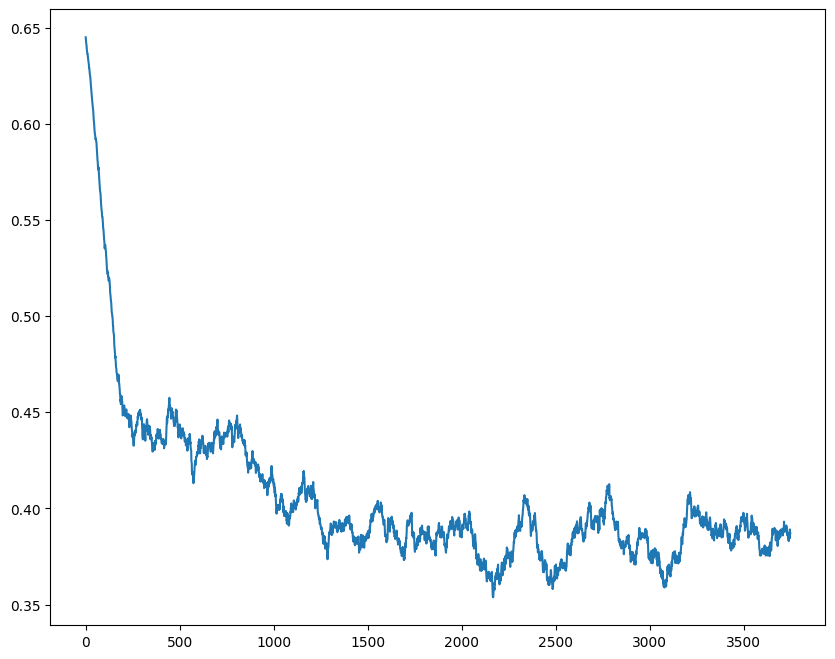

In [ ]:
window_size = 128

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

fix, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

# Инференс

In [ ]:
# загружаем сохраненный чекпойнт
dev = 'ekaterinatao/house-md-bot-bert-bi-encoder'

In [ ]:
dev_model = AutoModel.from_pretrained(dev)
dev_tok = AutoTokenizer.from_pretrained(dev)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# загружаем предобработанный датасет
dataset = datasets.load_dataset(config.dataset, split='train')
pd_dataset = pd.DataFrame(dataset)
all_qc = ['[SEP]'.join(data["context"]+data['question']) for data in dataset]
pd_dataset['q+c'] = all_qc
pd_dataset

,answer,question,context,labels,joined,q+c
0,I'm thinking the broken bones are a response t...,[Two surgeries for multiple fractures and burns.],"[Call 911., Twenty-six-year-old female, gas ma...",0,"Call 911. Twenty-six-year-old female, gas main...","Call 911.[SEP]Twenty-six-year-old female, gas ..."
1,I'm thinking the broken bones are a response t...,[Two surgeries for multiple fractures and burns.],"[Twenty-six-year-old female, gas main exploded...",0,"Twenty-six-year-old female, gas main exploded ...","Twenty-six-year-old female, gas main exploded ..."
2,I'm thinking the broken bones are a response t...,[Two surgeries for multiple fractures and burns.],[],0,[SEP] Two surgeries for multiple fractures and...,Two surgeries for multiple fractures and burns.
3,Put her on antipyretics.,[And the fEver? She's the only collapse victim...,[Two surgeries for multiple fractures and burn...,0,Two surgeries for multiple fractures and burns...,Two surgeries for multiple fractures and burns...
4,Put her on antipyretics.,[And the fEver? She's the only collapse victim...,[I'm thinking the broken bones are a response ...,0,I'm thinking the broken bones are a response t...,I'm thinking the broken bones are a response t...
...,...,...,...,...,...,...
77500,"You know it's the same, or you wouldn't be bic...","[If I kept it to myself, then it would just be...",[What's your point? That you cared about him m...,1,What's your point? That you cared about him mo...,What's your point? That you cared about him mo...
77501,"You know it's the same, or you wouldn't be bic...","[If I kept it to myself, then it would just be...",[],1,"[SEP] If I kept it to myself, then it would ju...","If I kept it to myself, then it would just be ..."
77502,But somewhere in there! he knew how to love.,[He wasn't always easy to deal with.],"[He made me a better parent, whether he meant ...",1,"He made me a better parent, whether he meant t...","He made me a better parent, whether he meant t..."
77503,But somewhere in there! he knew how to love.,[He wasn't always easy to deal with.],[He was willing to kill me. And I'll always be...,1,He was willing to kill me. And I'll always be ...,He was willing to kill me. And I'll always be ...


In [ ]:
# Получаем базу CLS векторов для всех вопросов с предшествующим контекстом
qc_base = np.array([
    embed_bert_cls(query, dev_model, dev_tok) for query in tqdm(pd_dataset['q+c'])
])

100%|██████████| 77505/77505 [08:22<00:00, 154.17it/s]


In [ ]:
np.save("qc_base", qc_base, allow_pickle=True)

Поиск топ k релевантных ответов на вопрос

In [ ]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeds = model_output.last_hidden_state[:, 0, :]
    embeds = torch.nn.functional.normalize(embeds)
    return embeds[0].cpu().numpy()

In [ ]:
# создаем базу векторов для быстрого поиска
index = faiss.IndexFlatL2(qc_base.shape[1])
index.add(qc_base)

In [ ]:
k=10
question = "Patient has joint pain, skin rash and acute kidney failure. I think he has lupus"

xq = embed_bert_cls(question, dev_model, dev_tok)
D, I = index.search(xq.reshape(1, 768), k)
for i, j in enumerate(I[0]):
    print(round(D[0][i], 3), pd_dataset['answer'][j])

0.12 Interesting.
0.127 Just thought you'd like to know.
0.129 Two major symptoms of anabolic steroid abuse.
0.132 HIV clinic. So few Patients, so much money;  re-do the tests.
0.132 Well, obviously not that mild. This keeps up and his hand will literally be dead meat. His hand is connected to his arm, his arm is connected to!I'm not sure, but I bet it's important.
0.138 Kidney failure means I was right about Amyloidosis.
0.145 You want to be here.
0.145 Cholecystitis?
0.147 You say no way I say! yeah, no way.
0.148 Finally! Someone who is NOT just a pretty face. You and Taub, run the 'scope, find the tumor.


In [ ]:
# При использовании в запросе точной реплики персонажа выдает со 100% уверенностью
# точную реплику Др.Хауса, следующую за репликой персонажа

k=4
question = 'When the cancer starts getting really bad!'

xq = embed_bert_cls(question, dev_model, dev_tok)
D, I = index.search(xq.reshape(1, 768), k)
for i, j in enumerate(I[0]):
    print(round(D[0][i], 3), pd_dataset['answer'][j])

0.0 Cancer's boring.
0.166 Any tingling in your arms or legs?
0.167 And you're so young.
0.18 No, it wasn't. Where's the bottle?
